In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

In [3]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip ms*.zip -d data/")
    
    print(f'Updated {date.today()}, max actual date: {prepare_data("WIG20").index.max()}')
    
def prepare_data(papier):
    
    if 'mst' in papier:
        df = pd.read_csv(f'data/{papier}')
    else:    
        df = pd.read_csv(f'data/{papier}.mst')
    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
    
    return df

In [4]:
update_stocks()

Updated 2020-04-09, max actual date: 2020-04-08 00:00:00


In [5]:
all_files = os.listdir('data/')
print(f'no of all available files: {len(all_files)}')

no of all available files: 1985


In [6]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

In [7]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

In [8]:
watch = ['PZU', 
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

## One one paper

In [9]:
[a for a in all_files if 'BIO' in a]

['MABION.mst', 'BIOTON.mst', 'BIOMEDLUB.mst']

In [11]:
papier = 'PLAY'

In [12]:
plot_paper(papier,'2008-07-15','2008-11-15')

'Nothing to show!'

/home/show/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


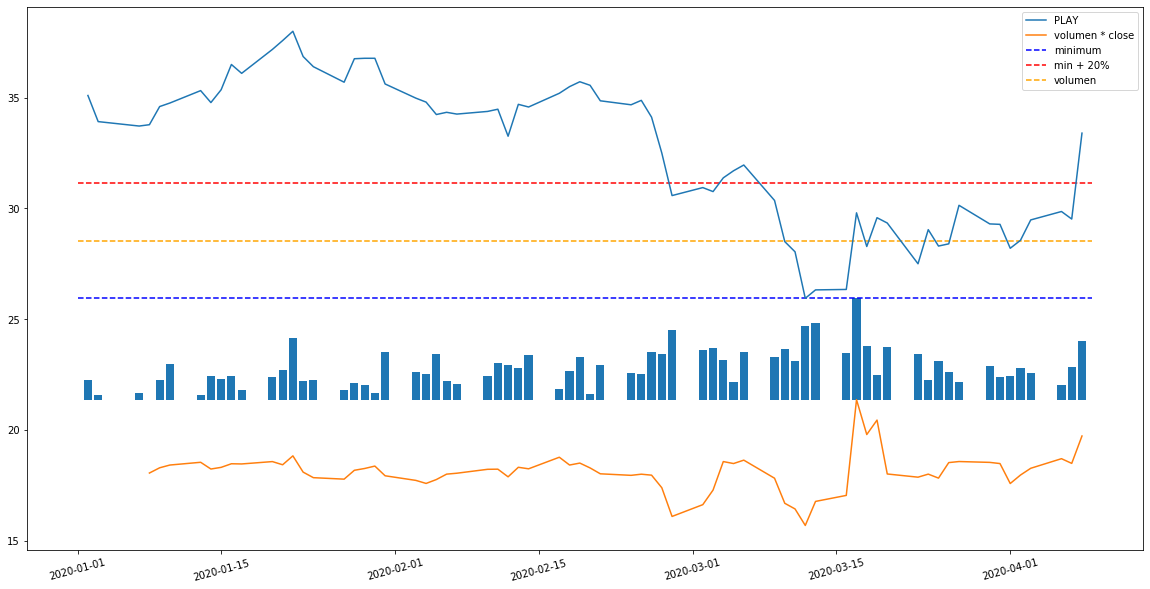

In [13]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [14]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [15]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: PLAY, currently at 33.4, with potential 13.77% to top
Max before crisis: 38.0
Crisis bottom: 25.94
Max after crisis drop: 33.4, at 2020-04-08 00:00:00
Stats after Max: [33.4]


## Skaner

In [16]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = ['ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
           'crisis_bottom', 
           'max_after_crisis', 'max_before_crisis']

### All papers

In [17]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_files):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1985/1985 [00:16<00:00, 117.47it/s]


In [18]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)


In [55]:
skaner_df_see = skaner_df.loc[
#     (skaner_df.growth_quarter > 0) 
#         & (skaner_df.growth_mid > 0) 
         (skaner_df.drop_current < 0) 
        & (skaner_df.growth_current > 0)
                              ,:].sort_values('drop_current', ascending=True)

In [56]:
skaner_df_see.sort_values('growth_current', ascending=False)

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,INTLPAL25031,318.20,NaN,103.30,NaN,61.00,375.10,389.80,NaN,NaN,514.92,421.64,22.50,-18.37
0,RCFL4PGN,0.19,0.32,1.13,2.84,0.04,0.20,1.39,-71.68,-60.21,400.00,375.00,631.58,-86.33
0,INTLPAL25049,349.00,NaN,123.60,NaN,91.00,396.50,389.60,NaN,NaN,335.71,283.52,11.63,-10.42
0,INTLSPX23622,26.47,NaN,38.31,NaN,7.15,28.10,52.95,NaN,NaN,293.01,270.21,100.04,-50.01
0,RCFL4PKN,0.47,1.32,NaN,4.71,0.13,0.47,6.50,NaN,NaN,261.54,261.54,1282.98,-92.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,INGBSK,134.40,195.00,198.20,190.00,134.00,170.20,207.00,-1.61,4.32,27.01,0.30,54.02,-35.07
0,BNPPSOLE0720,970.30,NaN,NaN,NaN,967.60,970.30,1016.70,NaN,NaN,0.28,0.28,4.78,-4.56
0,RCSDGP0421,1020.10,NaN,NaN,NaN,1018.00,1020.90,1071.70,NaN,NaN,0.28,0.21,5.06,-4.81
0,TALANX,150.30,NaN,NaN,NaN,150.00,161.00,192.00,NaN,NaN,7.33,0.20,27.74,-21.72


### WIG

In [84]:
skaner_wig_df = pd.DataFrame(columns=df_cols)
for w in tqdm([a for a in all_files if 'WIG' in a]):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_wig_df = pd.concat([skaner_wig_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 50/50 [00:00<00:00, 141.45it/s]


In [85]:
skaner_wig_df.loc[:,'growth_quarter'] = round(skaner_wig_df.loc[:,'before_crisis'] * 100 / skaner_wig_df.loc[:,'last_y_q'] - 100, 2)
skaner_wig_df.loc[:,'growth_mid'] = round(skaner_wig_df.loc[:,'last_y_q'] * 100 / skaner_wig_df.loc[:,'last_y_mid'] - 100, 2)
skaner_wig_df.loc[:,'growth_from_crisis'] = round(skaner_wig_df.loc[:,'max_after_crisis'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'growth_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'drop_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'max_before_crisis'] - 100, 2)


In [86]:
skaner_wig_df_see = skaner_wig_df.loc[(skaner_wig_df.growth_quarter > 0) & 
         (skaner_wig_df.growth_mid > 0) & 
          (skaner_wig_df.drop_current < -15) &
          (skaner_wig_df.growth_current > 10),:].sort_values('drop_current', ascending=True)

In [87]:
skaner_wig_df.sort_values('growth_current')

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,drop_current
0,RCLMWIG40AOPEN,29.15,NaN,NaN,NaN,29.15,29.15,39.31,NaN,NaN,0.00,0.00,-25.85
0,SWIG80DVP,0.94,NaN,371.67,97.65,0.94,0.94,410.71,NaN,280.61,0.00,0.00,-99.77
0,WIG-BANKI,3931.74,6852.02,7073.65,7513.37,3931.74,4406.52,7327.60,-3.13,-5.85,12.08,0.00,-46.34
0,MWIG40DVP,0.57,0.57,110.86,38.96,0.57,0.57,117.22,-99.49,184.55,0.00,0.00,-99.51
0,WIG-NRCHOM,1834.45,2610.21,2288.28,2110.54,1834.45,2132.56,2610.21,14.07,8.42,16.25,0.00,-29.72
0,RCBMWIG401121,748.10,NaN,NaN,NaN,748.10,748.10,1005.60,NaN,NaN,0.00,0.00,-25.61
0,RCFS2MWIG40,20.29,NaN,NaN,NaN,20.29,20.29,NaN,NaN,NaN,0.00,0.00,NaN
0,WIG20SHORT,4943.90,3696.44,3633.11,3490.73,4925.06,5623.80,3826.33,1.74,4.08,14.19,0.38,29.21
0,WIG.MS-FIN,6130.43,10041.71,10343.27,11200.03,6047.16,6612.93,10700.18,-2.92,-7.65,9.36,1.38,-42.71
0,MWIG40TR,3722.18,5299.43,4779.99,5029.64,3603.52,3869.21,5339.13,10.87,-4.96,7.37,3.29,-30.28


## Monitoring

In [211]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [219]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [220]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 124.44it/s]


In [214]:
df_stats = pd.DataFrame()

In [223]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [232]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

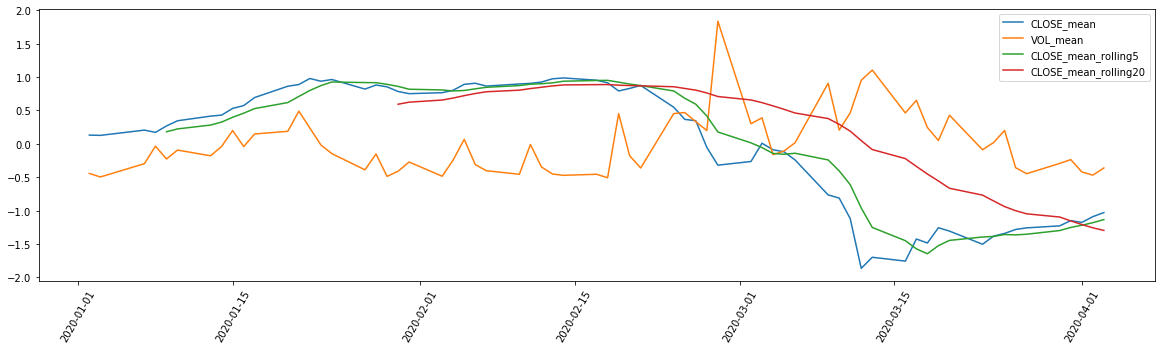

In [234]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [23]:
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix

In [57]:
df_merged = pd.DataFrame()

for p in tqdm(skaner_df_see.ticker.values):
    df = prepare_data(p)

    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'bin_' + col] = 0
        df.loc[df.loc[:,col] > df.loc[:,col + '_shifted'],'bin_' + col] = 1

    df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
    for a in [c for c in df.columns if 'bin' in c]:
        for i in [1,2,3,4,5]:
            df.loc[:,f'binhist{i}_' + a] = df.loc[:,a].shift(i)
            
    for b in [c for c in df.columns if ('bin_' in c) & ('binhist' not in c)]:
        for g in [3, 5, 10, 20]:
            df.loc[:,f'binroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
    
    df = df.dropna()
    
    df_merged = pd.concat([df_merged, df])

100%|██████████| 591/591 [03:20<00:00,  2.94it/s]


In [ ]:
df_merged = pd.DataFrame()

for p in tqdm(skaner_df_see.ticker.values):
    df = prepare_data(p)

    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'bin_' + col] = 0
        df.loc[df.loc[:,col] > df.loc[:,col + '_shifted'],'bin_' + col] = 1

    df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
    for a in [c for c in df.columns if 'bin' in c]:
        for i in [1,2,3,4,5]:
            df.loc[:,f'binhist{i}_' + a] = df.loc[:,a].shift(i)
            
    for b in [c for c in df.columns if ('bin_' in c) & ('binhist' not in c)]:
        for g in [3, 5, 10, 20]:
            df.loc[:,f'binroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
    
    df = df.dropna()
    
    df_merged = pd.concat([df_merged, df])

In [58]:
df = df_merged.copy()

In [26]:
df_merged.loc[:, ['TICKER','bin_OPEN']].iloc[125:200,:].groupby('TICKER').shift(1)

,bin_OPEN
DTYYYYMMDD,
2008-05-13,NaN
2008-05-14,1.0
2008-05-15,0.0
2008-05-16,1.0
2008-05-19,0.0
2008-05-20,0.0
2008-05-21,1.0
2008-05-23,0.0
2008-05-26,0.0


In [28]:
#df_merged.loc[:, 'target'] = df_merged.loc[:, 'bin_OPEN'].shift(-1)

In [59]:
train_cols = [c for c in df.columns if 'bin' in c]

In [369]:
train_cols = [c for c in train_cols if '_binhist1_' not in c] 
train_cols = [c for c in train_cols if '_binhist2_' not in c] 
train_cols = [c for c in train_cols if '_binhist3_' not in c] 
train_cols = [c for c in train_cols if '_binhist4_' not in c] 
train_cols = [c for c in train_cols if '_binhist5_' not in c] 

In [398]:
train_cols = train_cols_limited

In [82]:
cut_date = '2020-01-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [83]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=2000,
                           learning_rate=0.05,
                           depth=4,
                          thread_count=4,
                          eval_metric='AUC')

In [84]:
model.fit(train_data, train_labels, 
          eval_set=(eval_data[:-1], eval_labels[:-1]),
         early_stopping_rounds=20, use_best_model=True)

0:	test: 0.7596217	best: 0.7596217 (0)	total: 182ms	remaining: 6m 4s
1:	test: 0.7596217	best: 0.7596217 (0)	total: 373ms	remaining: 6m 12s
2:	test: 0.7596217	best: 0.7596217 (0)	total: 563ms	remaining: 6m 14s
3:	test: 0.7596217	best: 0.7596217 (0)	total: 731ms	remaining: 6m 4s
4:	test: 0.7623666	best: 0.7623666 (4)	total: 907ms	remaining: 6m 1s
5:	test: 0.7623666	best: 0.7623666 (4)	total: 1.07s	remaining: 5m 56s
6:	test: 0.7623666	best: 0.7623666 (4)	total: 1.25s	remaining: 5m 55s
7:	test: 0.7623639	best: 0.7623666 (4)	total: 1.42s	remaining: 5m 53s
8:	test: 0.7650198	best: 0.7650198 (8)	total: 1.6s	remaining: 5m 54s
9:	test: 0.7649797	best: 0.7650198 (8)	total: 1.78s	remaining: 5m 53s
10:	test: 0.7654939	best: 0.7654939 (10)	total: 1.96s	remaining: 5m 54s
11:	test: 0.7659518	best: 0.7659518 (11)	total: 2.13s	remaining: 5m 52s
12:	test: 0.7659820	best: 0.7659820 (12)	total: 2.31s	remaining: 5m 52s
13:	test: 0.7670552	best: 0.7670552 (13)	total: 2.48s	remaining: 5m 52s
14:	test: 0.7670

115:	test: 0.7700885	best: 0.7700911 (114)	total: 20.5s	remaining: 5m 33s
116:	test: 0.7700846	best: 0.7700911 (114)	total: 20.7s	remaining: 5m 33s
117:	test: 0.7700710	best: 0.7700911 (114)	total: 20.9s	remaining: 5m 33s
118:	test: 0.7700688	best: 0.7700911 (114)	total: 21s	remaining: 5m 32s
119:	test: 0.7700790	best: 0.7700911 (114)	total: 21.2s	remaining: 5m 32s
120:	test: 0.7700825	best: 0.7700911 (114)	total: 21.4s	remaining: 5m 31s
121:	test: 0.7700814	best: 0.7700911 (114)	total: 21.5s	remaining: 5m 31s
122:	test: 0.7700816	best: 0.7700911 (114)	total: 21.7s	remaining: 5m 31s
123:	test: 0.7701307	best: 0.7701307 (123)	total: 21.9s	remaining: 5m 31s
124:	test: 0.7701403	best: 0.7701403 (124)	total: 22.1s	remaining: 5m 30s
125:	test: 0.7702038	best: 0.7702038 (125)	total: 22.2s	remaining: 5m 30s
126:	test: 0.7701993	best: 0.7702038 (125)	total: 22.4s	remaining: 5m 30s
127:	test: 0.7701903	best: 0.7702038 (125)	total: 22.6s	remaining: 5m 30s
128:	test: 0.7701981	best: 0.7702038 (12

227:	test: 0.7711464	best: 0.7711464 (227)	total: 39.8s	remaining: 5m 9s
228:	test: 0.7711453	best: 0.7711464 (227)	total: 40s	remaining: 5m 9s
229:	test: 0.7711461	best: 0.7711464 (227)	total: 40.2s	remaining: 5m 9s
230:	test: 0.7711394	best: 0.7711464 (227)	total: 40.4s	remaining: 5m 9s
231:	test: 0.7711527	best: 0.7711527 (231)	total: 40.6s	remaining: 5m 9s
232:	test: 0.7711609	best: 0.7711609 (232)	total: 40.7s	remaining: 5m 9s
233:	test: 0.7711567	best: 0.7711609 (232)	total: 40.9s	remaining: 5m 8s
234:	test: 0.7711675	best: 0.7711675 (234)	total: 41.1s	remaining: 5m 8s
235:	test: 0.7711777	best: 0.7711777 (235)	total: 41.3s	remaining: 5m 9s
236:	test: 0.7711882	best: 0.7711882 (236)	total: 41.6s	remaining: 5m 9s
237:	test: 0.7711847	best: 0.7711882 (236)	total: 41.8s	remaining: 5m 9s
238:	test: 0.7712005	best: 0.7712005 (238)	total: 42s	remaining: 5m 9s
239:	test: 0.7712004	best: 0.7712005 (238)	total: 42.2s	remaining: 5m 9s
240:	test: 0.7711993	best: 0.7712005 (238)	total: 42.4s

340:	test: 0.7718824	best: 0.7718824 (340)	total: 1m	remaining: 4m 52s
341:	test: 0.7718944	best: 0.7718944 (341)	total: 1m	remaining: 4m 51s
342:	test: 0.7718964	best: 0.7718964 (342)	total: 1m	remaining: 4m 51s
343:	test: 0.7719042	best: 0.7719042 (343)	total: 1m	remaining: 4m 51s
344:	test: 0.7719057	best: 0.7719057 (344)	total: 1m	remaining: 4m 51s
345:	test: 0.7719075	best: 0.7719075 (345)	total: 1m	remaining: 4m 50s
346:	test: 0.7719092	best: 0.7719092 (346)	total: 1m 1s	remaining: 4m 50s
347:	test: 0.7719139	best: 0.7719139 (347)	total: 1m 1s	remaining: 4m 50s
348:	test: 0.7719206	best: 0.7719206 (348)	total: 1m 1s	remaining: 4m 50s
349:	test: 0.7719274	best: 0.7719274 (349)	total: 1m 1s	remaining: 4m 50s
350:	test: 0.7719255	best: 0.7719274 (349)	total: 1m 1s	remaining: 4m 49s
351:	test: 0.7719288	best: 0.7719288 (351)	total: 1m 1s	remaining: 4m 49s
352:	test: 0.7719184	best: 0.7719288 (351)	total: 1m 2s	remaining: 4m 49s
353:	test: 0.7719172	best: 0.7719288 (351)	total: 1m 2s	

451:	test: 0.7725572	best: 0.7725596 (450)	total: 1m 19s	remaining: 4m 31s
452:	test: 0.7725581	best: 0.7725596 (450)	total: 1m 19s	remaining: 4m 31s
453:	test: 0.7725567	best: 0.7725596 (450)	total: 1m 19s	remaining: 4m 31s
454:	test: 0.7725527	best: 0.7725596 (450)	total: 1m 19s	remaining: 4m 31s
455:	test: 0.7725595	best: 0.7725596 (450)	total: 1m 20s	remaining: 4m 31s
456:	test: 0.7725627	best: 0.7725627 (456)	total: 1m 20s	remaining: 4m 30s
457:	test: 0.7725573	best: 0.7725627 (456)	total: 1m 20s	remaining: 4m 30s
458:	test: 0.7725675	best: 0.7725675 (458)	total: 1m 20s	remaining: 4m 30s
459:	test: 0.7725713	best: 0.7725713 (459)	total: 1m 20s	remaining: 4m 30s
460:	test: 0.7725690	best: 0.7725713 (459)	total: 1m 20s	remaining: 4m 30s
461:	test: 0.7725652	best: 0.7725713 (459)	total: 1m 21s	remaining: 4m 30s
462:	test: 0.7725758	best: 0.7725758 (462)	total: 1m 21s	remaining: 4m 29s
463:	test: 0.7725736	best: 0.7725758 (462)	total: 1m 21s	remaining: 4m 29s
464:	test: 0.7725754	best

561:	test: 0.7729389	best: 0.7729389 (561)	total: 1m 39s	remaining: 4m 15s
562:	test: 0.7729398	best: 0.7729398 (562)	total: 1m 40s	remaining: 4m 15s
563:	test: 0.7729445	best: 0.7729445 (563)	total: 1m 40s	remaining: 4m 15s
564:	test: 0.7729539	best: 0.7729539 (564)	total: 1m 40s	remaining: 4m 15s
565:	test: 0.7729529	best: 0.7729539 (564)	total: 1m 40s	remaining: 4m 15s
566:	test: 0.7729552	best: 0.7729552 (566)	total: 1m 40s	remaining: 4m 14s
567:	test: 0.7729612	best: 0.7729612 (567)	total: 1m 41s	remaining: 4m 14s
568:	test: 0.7729725	best: 0.7729725 (568)	total: 1m 41s	remaining: 4m 14s
569:	test: 0.7729656	best: 0.7729725 (568)	total: 1m 41s	remaining: 4m 14s
570:	test: 0.7729688	best: 0.7729725 (568)	total: 1m 41s	remaining: 4m 14s
571:	test: 0.7729808	best: 0.7729808 (571)	total: 1m 41s	remaining: 4m 13s
572:	test: 0.7729819	best: 0.7729819 (572)	total: 1m 41s	remaining: 4m 13s
573:	test: 0.7729803	best: 0.7729819 (572)	total: 1m 42s	remaining: 4m 13s
574:	test: 0.7729842	best

673:	test: 0.7733033	best: 0.7733041 (672)	total: 2m 1s	remaining: 3m 58s
674:	test: 0.7732984	best: 0.7733041 (672)	total: 2m 1s	remaining: 3m 58s
675:	test: 0.7732998	best: 0.7733041 (672)	total: 2m 1s	remaining: 3m 58s
676:	test: 0.7733003	best: 0.7733041 (672)	total: 2m 1s	remaining: 3m 57s
677:	test: 0.7733015	best: 0.7733041 (672)	total: 2m 1s	remaining: 3m 57s
678:	test: 0.7733006	best: 0.7733041 (672)	total: 2m 2s	remaining: 3m 57s
679:	test: 0.7733005	best: 0.7733041 (672)	total: 2m 2s	remaining: 3m 57s
680:	test: 0.7733038	best: 0.7733041 (672)	total: 2m 2s	remaining: 3m 57s
681:	test: 0.7733044	best: 0.7733044 (681)	total: 2m 2s	remaining: 3m 57s
682:	test: 0.7733248	best: 0.7733248 (682)	total: 2m 2s	remaining: 3m 57s
683:	test: 0.7733246	best: 0.7733248 (682)	total: 2m 3s	remaining: 3m 56s
684:	test: 0.7733207	best: 0.7733248 (682)	total: 2m 3s	remaining: 3m 56s
685:	test: 0.7733197	best: 0.7733248 (682)	total: 2m 3s	remaining: 3m 56s
686:	test: 0.7733212	best: 0.7733248 (

784:	test: 0.7735002	best: 0.7735021 (770)	total: 2m 23s	remaining: 3m 42s
785:	test: 0.7735100	best: 0.7735100 (785)	total: 2m 23s	remaining: 3m 42s
786:	test: 0.7735125	best: 0.7735125 (786)	total: 2m 23s	remaining: 3m 41s
787:	test: 0.7735118	best: 0.7735125 (786)	total: 2m 24s	remaining: 3m 41s
788:	test: 0.7735159	best: 0.7735159 (788)	total: 2m 24s	remaining: 3m 41s
789:	test: 0.7735161	best: 0.7735161 (789)	total: 2m 24s	remaining: 3m 41s
790:	test: 0.7735132	best: 0.7735161 (789)	total: 2m 24s	remaining: 3m 41s
791:	test: 0.7735108	best: 0.7735161 (789)	total: 2m 24s	remaining: 3m 41s
792:	test: 0.7735195	best: 0.7735195 (792)	total: 2m 25s	remaining: 3m 40s
793:	test: 0.7735216	best: 0.7735216 (793)	total: 2m 25s	remaining: 3m 40s
794:	test: 0.7735140	best: 0.7735216 (793)	total: 2m 25s	remaining: 3m 40s
795:	test: 0.7735151	best: 0.7735216 (793)	total: 2m 25s	remaining: 3m 40s
796:	test: 0.7735189	best: 0.7735216 (793)	total: 2m 25s	remaining: 3m 40s
797:	test: 0.7735143	best

895:	test: 0.7737063	best: 0.7737219 (889)	total: 2m 44s	remaining: 3m 22s
896:	test: 0.7737101	best: 0.7737219 (889)	total: 2m 44s	remaining: 3m 22s
897:	test: 0.7737030	best: 0.7737219 (889)	total: 2m 44s	remaining: 3m 22s
898:	test: 0.7737083	best: 0.7737219 (889)	total: 2m 44s	remaining: 3m 21s
899:	test: 0.7737099	best: 0.7737219 (889)	total: 2m 45s	remaining: 3m 21s
900:	test: 0.7737105	best: 0.7737219 (889)	total: 2m 45s	remaining: 3m 21s
901:	test: 0.7737176	best: 0.7737219 (889)	total: 2m 45s	remaining: 3m 21s
902:	test: 0.7737268	best: 0.7737268 (902)	total: 2m 45s	remaining: 3m 21s
903:	test: 0.7737285	best: 0.7737285 (903)	total: 2m 45s	remaining: 3m 21s
904:	test: 0.7737347	best: 0.7737347 (904)	total: 2m 46s	remaining: 3m 20s
905:	test: 0.7737352	best: 0.7737352 (905)	total: 2m 46s	remaining: 3m 20s
906:	test: 0.7737345	best: 0.7737352 (905)	total: 2m 46s	remaining: 3m 20s
907:	test: 0.7737339	best: 0.7737352 (905)	total: 2m 46s	remaining: 3m 20s
908:	test: 0.7737292	best

1006:	test: 0.7739011	best: 0.7739021 (1004)	total: 3m 6s	remaining: 3m 3s
1007:	test: 0.7739031	best: 0.7739031 (1007)	total: 3m 6s	remaining: 3m 3s
1008:	test: 0.7739012	best: 0.7739031 (1007)	total: 3m 6s	remaining: 3m 3s
1009:	test: 0.7738995	best: 0.7739031 (1007)	total: 3m 6s	remaining: 3m 3s
1010:	test: 0.7738999	best: 0.7739031 (1007)	total: 3m 6s	remaining: 3m 2s
1011:	test: 0.7738973	best: 0.7739031 (1007)	total: 3m 7s	remaining: 3m 2s
1012:	test: 0.7738973	best: 0.7739031 (1007)	total: 3m 7s	remaining: 3m 2s
1013:	test: 0.7738937	best: 0.7739031 (1007)	total: 3m 7s	remaining: 3m 2s
1014:	test: 0.7738961	best: 0.7739031 (1007)	total: 3m 7s	remaining: 3m 2s
1015:	test: 0.7738998	best: 0.7739031 (1007)	total: 3m 7s	remaining: 3m 1s
1016:	test: 0.7739112	best: 0.7739112 (1016)	total: 3m 8s	remaining: 3m 1s
1017:	test: 0.7739100	best: 0.7739112 (1016)	total: 3m 8s	remaining: 3m 1s
1018:	test: 0.7739112	best: 0.7739112 (1018)	total: 3m 8s	remaining: 3m 1s
1019:	test: 0.7739192	bes

1114:	test: 0.7740749	best: 0.7740749 (1114)	total: 3m 26s	remaining: 2m 43s
1115:	test: 0.7740820	best: 0.7740820 (1115)	total: 3m 26s	remaining: 2m 43s
1116:	test: 0.7740850	best: 0.7740850 (1116)	total: 3m 26s	remaining: 2m 43s
1117:	test: 0.7740877	best: 0.7740877 (1117)	total: 3m 27s	remaining: 2m 43s
1118:	test: 0.7740848	best: 0.7740877 (1117)	total: 3m 27s	remaining: 2m 43s
1119:	test: 0.7740887	best: 0.7740887 (1119)	total: 3m 27s	remaining: 2m 43s
1120:	test: 0.7740888	best: 0.7740888 (1120)	total: 3m 27s	remaining: 2m 42s
1121:	test: 0.7740880	best: 0.7740888 (1120)	total: 3m 27s	remaining: 2m 42s
1122:	test: 0.7740872	best: 0.7740888 (1120)	total: 3m 28s	remaining: 2m 42s
1123:	test: 0.7740822	best: 0.7740888 (1120)	total: 3m 28s	remaining: 2m 42s
1124:	test: 0.7740814	best: 0.7740888 (1120)	total: 3m 28s	remaining: 2m 42s
1125:	test: 0.7740843	best: 0.7740888 (1120)	total: 3m 28s	remaining: 2m 41s
1126:	test: 0.7740863	best: 0.7740888 (1120)	total: 3m 28s	remaining: 2m 41s

1221:	test: 0.7742000	best: 0.7742000 (1221)	total: 3m 46s	remaining: 2m 24s
1222:	test: 0.7741997	best: 0.7742000 (1221)	total: 3m 46s	remaining: 2m 24s
1223:	test: 0.7742033	best: 0.7742033 (1223)	total: 3m 46s	remaining: 2m 23s
1224:	test: 0.7742034	best: 0.7742034 (1224)	total: 3m 47s	remaining: 2m 23s
1225:	test: 0.7742063	best: 0.7742063 (1225)	total: 3m 47s	remaining: 2m 23s
1226:	test: 0.7742042	best: 0.7742063 (1225)	total: 3m 47s	remaining: 2m 23s
1227:	test: 0.7742047	best: 0.7742063 (1225)	total: 3m 47s	remaining: 2m 23s
1228:	test: 0.7742086	best: 0.7742086 (1228)	total: 3m 48s	remaining: 2m 23s
1229:	test: 0.7742067	best: 0.7742086 (1228)	total: 3m 48s	remaining: 2m 22s
1230:	test: 0.7742062	best: 0.7742086 (1228)	total: 3m 48s	remaining: 2m 22s
1231:	test: 0.7742069	best: 0.7742086 (1228)	total: 3m 48s	remaining: 2m 22s
1232:	test: 0.7742067	best: 0.7742086 (1228)	total: 3m 48s	remaining: 2m 22s
1233:	test: 0.7742067	best: 0.7742086 (1228)	total: 3m 49s	remaining: 2m 22s

In [85]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,bin_CLOSE,49.601046
1,bin_OPEN,20.343223
2,bin_HIGH,7.433904
3,bin_LOW,4.406105
4,binhist1_bin_CLOSE,2.711701
5,bin_VOL,2.270223
6,binroll20m_bin_HIGH,1.809264
7,binroll20m_bin_OPEN,1.151457
8,binhist1_bin_OPEN,1.139351
9,binroll3m_bin_CLOSE,0.958470


In [86]:
imp = model.get_feature_importance(prettified=True)

In [87]:
train_cols_limited  = imp.loc[imp.Importances > 1, 'Feature Id'].values

In [88]:
train_cols_limited

array(['bin_CLOSE', 'bin_OPEN', 'bin_HIGH', 'bin_LOW',
       'binhist1_bin_CLOSE', 'bin_VOL', 'binroll20m_bin_HIGH',
       'binroll20m_bin_OPEN', 'binhist1_bin_OPEN'], dtype=object)

In [89]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

In [90]:
confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int))

array([[14166,  3077],
       [ 4973,  7334]])

In [91]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(14166, 3077, 4973, 7334)

In [92]:
(tn + tp) / (tn + tp + fp + fn)

0.727580372250423

In [93]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)

In [94]:
df_res.columns = ['zero', 'one', 'true']

In [95]:
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.673079,0.326921
1.0,0.447430,0.552570


In [96]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

In [97]:
df_res_grouped = df_res.drop('zero', axis = 1)

In [98]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

In [99]:
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

In [100]:
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

In [101]:
df_res_grouped = df_res_grouped.reset_index().set_index('one')

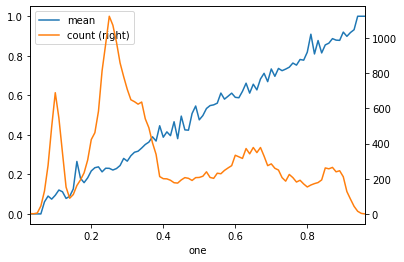

In [102]:
df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [103]:
df_res_grouped

,mean,count
one,,
0.03,0.000000,3
0.04,0.000000,2
0.05,0.000000,6
0.06,0.000000,46
0.07,0.061069,131
0.08,0.090253,277
0.09,0.074747,495
0.10,0.094340,689
0.11,0.120879,546


## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
